In [1]:
# 🤖 Importación de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import streamlit as st
import holidays

In [2]:
# 🤖 Carga de datos desde data/raw/entrenamiento
ventas_df = pd.read_csv('../data/raw/entrenamiento/ventas.csv')
competencia_df = pd.read_csv('../data/raw/entrenamiento/competencia.csv')

In [10]:
# 🤖 Conversión de la columna fecha a tipo datetime
competencia_df['fecha'] = pd.to_datetime(competencia_df['fecha'])
ventas_df['fecha'] = pd.to_datetime(ventas_df['fecha'])

In [11]:
# 🤖 Integración de datos de ventas y competencia
# Unimos los dataframes usando fecha y producto_id como claves

df = pd.merge(ventas_df, competencia_df, on=['fecha', 'producto_id'], how='inner')
df.head()

,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,Amazon,Decathlon,Deporvillage
0,2021-10-25,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,6,118.36,710.16,82.96,111.88,97.43
1,2021-10-25,PROD_002,Adidas Ultraboost 23,Running,Zapatillas Running,135,True,10,136.82,1368.20,112.56,108.61,115.58
2,2021-10-25,PROD_003,Asics Gel Nimbus 25,Running,Zapatillas Running,85,False,2,84.93,169.86,79.79,78.44,80.11
3,2021-10-25,PROD_004,New Balance Fresh Foam X 1080v12,Running,Zapatillas Running,75,False,2,75.42,150.84,72.60,67.29,74.45
4,2021-10-25,PROD_005,Nike Dri-FIT Miler,Running,Ropa Running,35,False,2,35.87,71.74,37.71,33.60,33.07


In [18]:
df.columns

Index(['fecha', 'producto_id', 'nombre', 'categoria', 'subcategoria',
       'precio_base', 'es_estrella', 'unidades_vendidas', 'precio_venta',
       'ingresos', 'Amazon', 'Decathlon', 'Deporvillage', 'dia_semana'],
      dtype='object')

# 🤖 Análisis exploratorio completo del dataframe integrado (df)
A continuación se presentan diferentes análisis y visualizaciones para entender el comportamiento de las ventas y la competencia.

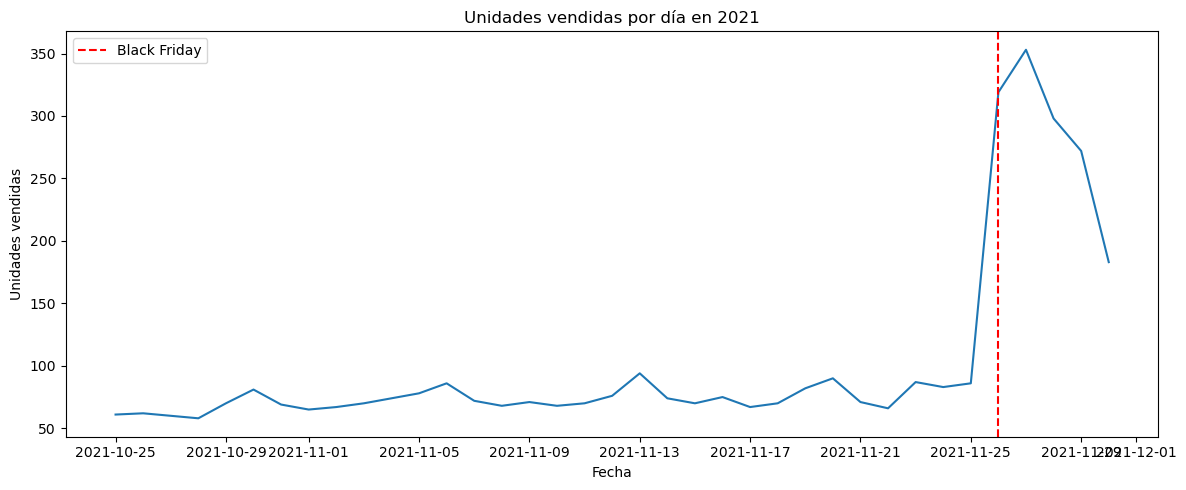

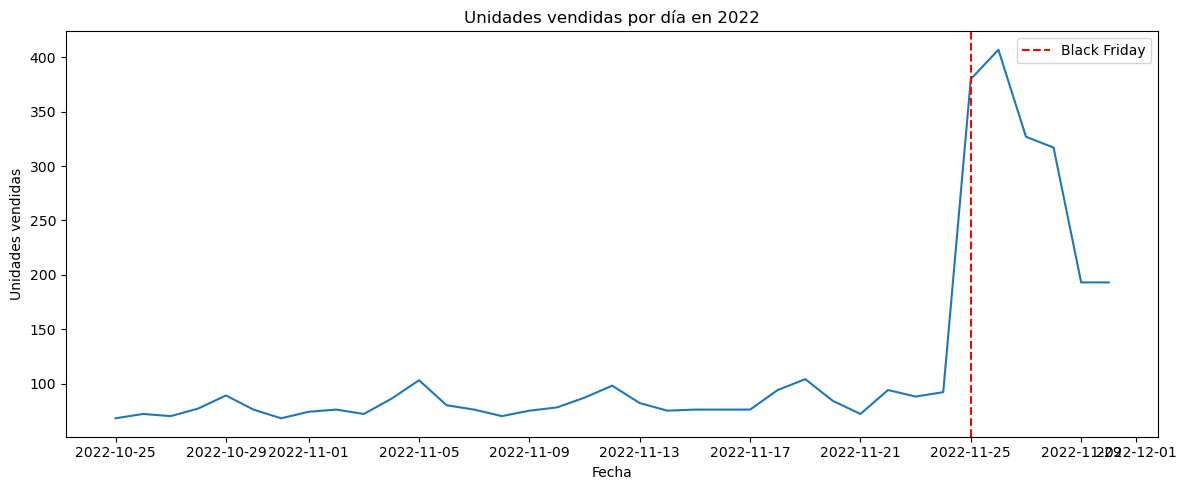

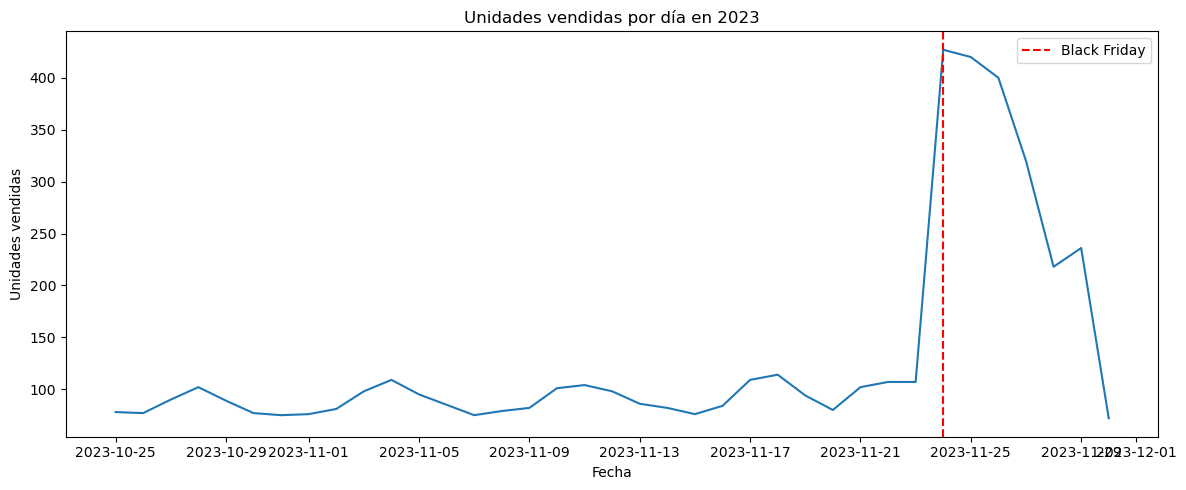

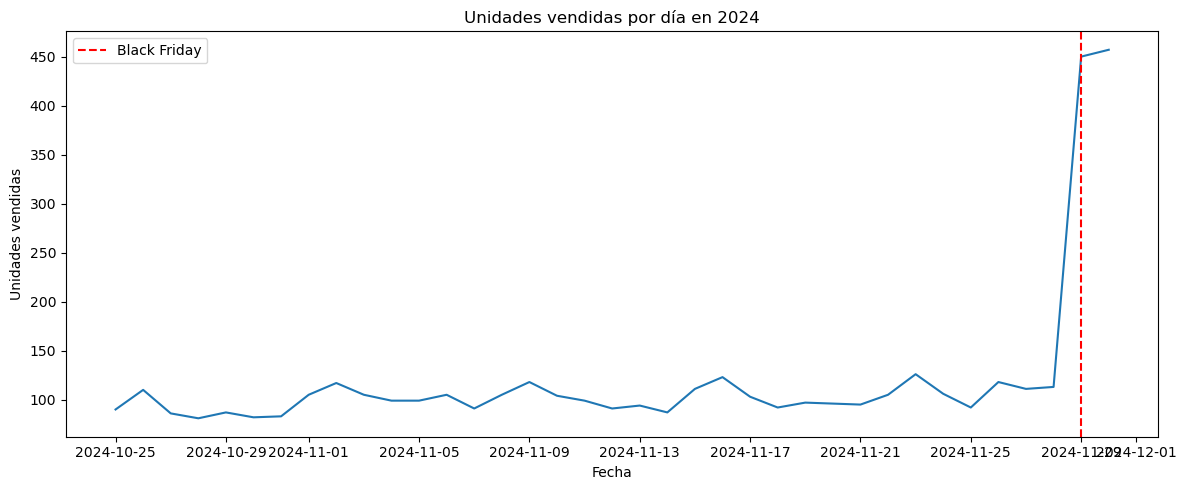

In [17]:
# 🤖 Línea temporal de unidades vendidas por año, marcando Black Fridays
for year in df['fecha'].dt.year.unique():
    plt.figure(figsize=(12,5))
    df_year = df[df['fecha'].dt.year == year]
    df_year_grouped = df_year.groupby('fecha')['unidades_vendidas'].sum().reset_index()
    sns.lineplot(data=df_year_grouped, x='fecha', y='unidades_vendidas')
    # Calcular el último viernes de noviembre (Black Friday)
    noviembre = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='D')
    viernes_noviembre = noviembre[noviembre.weekday == 4]
    if len(viernes_noviembre) > 0:
        black_friday = viernes_noviembre[-1]
        plt.axvline(black_friday, color='red', linestyle='--', label='Black Friday')
    plt.title(f'Unidades vendidas por día en {year}')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.tight_layout()
    plt.show()

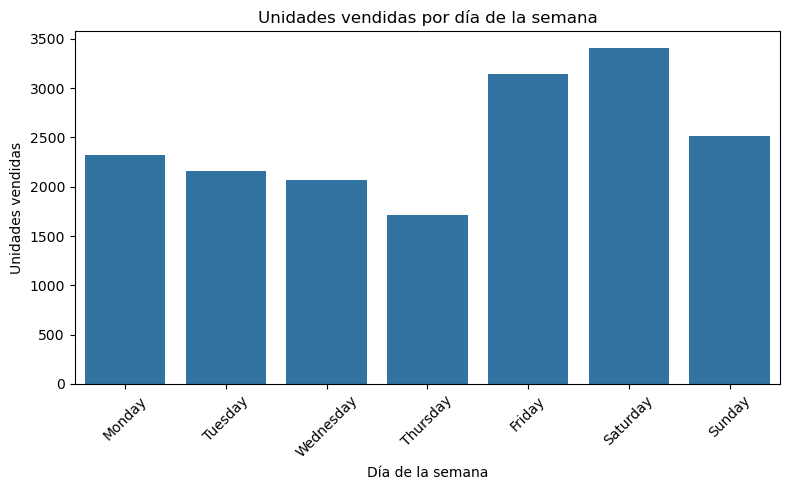

In [13]:
# 🤖 Unidades vendidas por día de la semana
plt.figure(figsize=(8,5))
df['dia_semana'] = df['fecha'].dt.day_name()
dia_semana_grouped = df.groupby('dia_semana')['unidades_vendidas'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=dia_semana_grouped.index, y=dia_semana_grouped.values)
plt.title('Unidades vendidas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

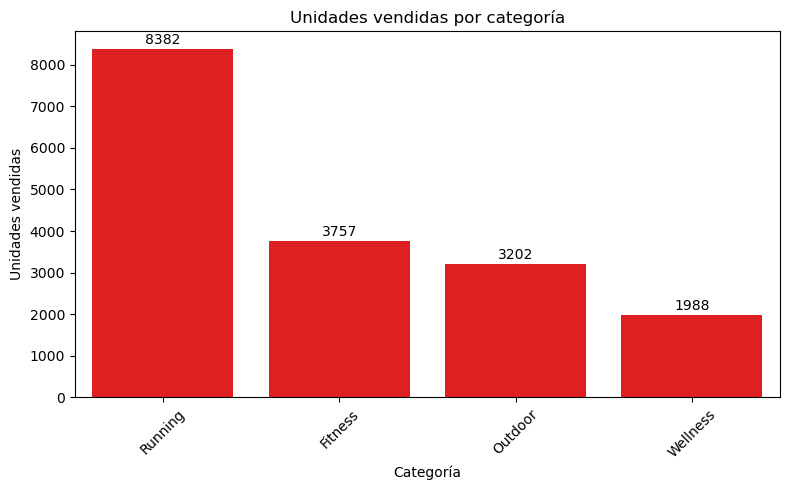

In [16]:
# 🤖 Unidades vendidas por categoría
plt.figure(figsize=(8,5))
categoria_grouped = df.groupby('categoria')['unidades_vendidas'].sum().sort_values(ascending=False)
ax = sns.barplot(x=categoria_grouped.index, y=categoria_grouped.values, color='red')

# Añadir etiquetas con los valores en cada barra
for i, v in enumerate(categoria_grouped.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom')

plt.title('Unidades vendidas por categoría')
plt.xlabel('Categoría')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

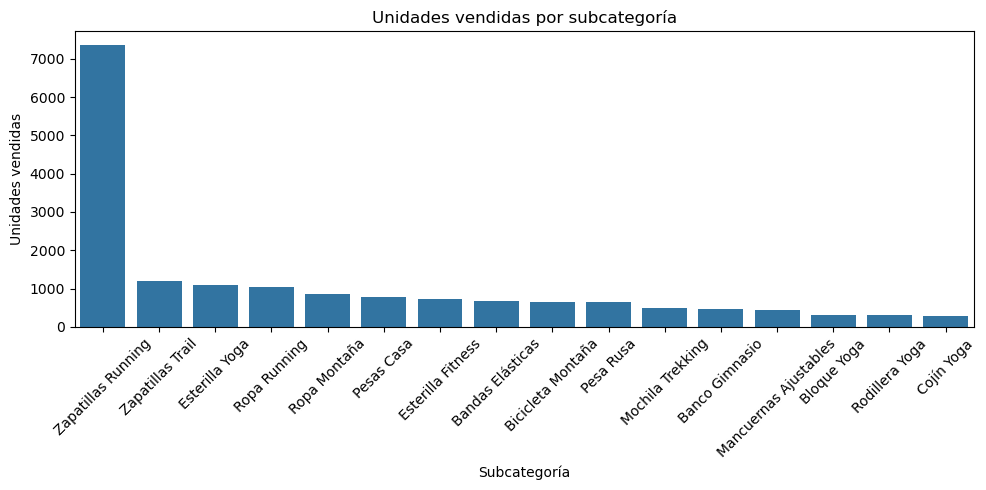

In [19]:
# 🤖 Unidades vendidas por subcategoría
plt.figure(figsize=(10,5))
subcategoria_grouped = df.groupby('subcategoria')['unidades_vendidas'].sum().sort_values(ascending=False)
sns.barplot(x=subcategoria_grouped.index, y=subcategoria_grouped.values)
plt.title('Unidades vendidas por subcategoría')
plt.xlabel('Subcategoría')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

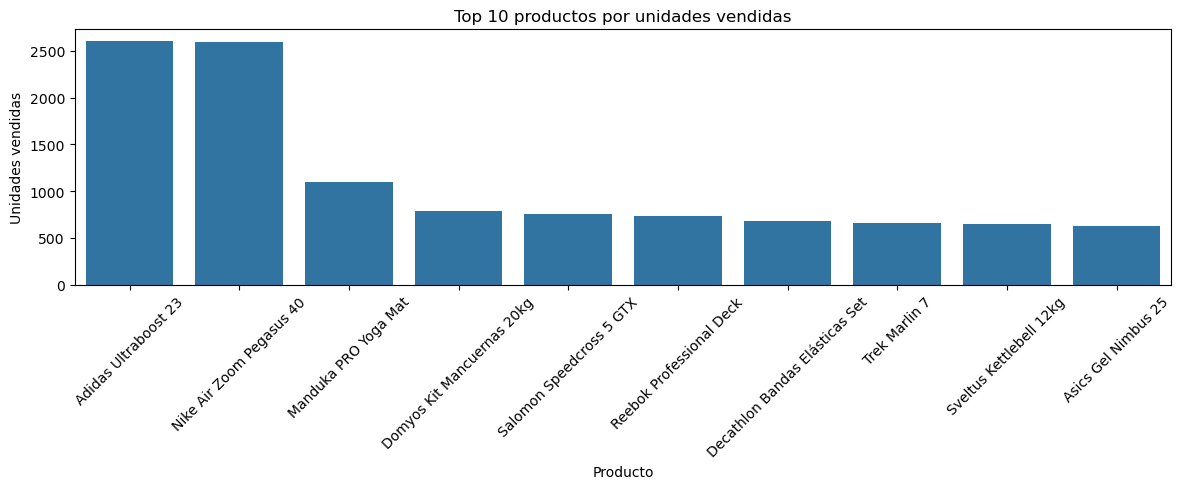

In [20]:
# 🤖 Unidades vendidas por top productos
plt.figure(figsize=(12,5))
top_productos = df.groupby('nombre')['unidades_vendidas'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_productos.index, y=top_productos.values)
plt.title('Top 10 productos por unidades vendidas')
plt.xlabel('Producto')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

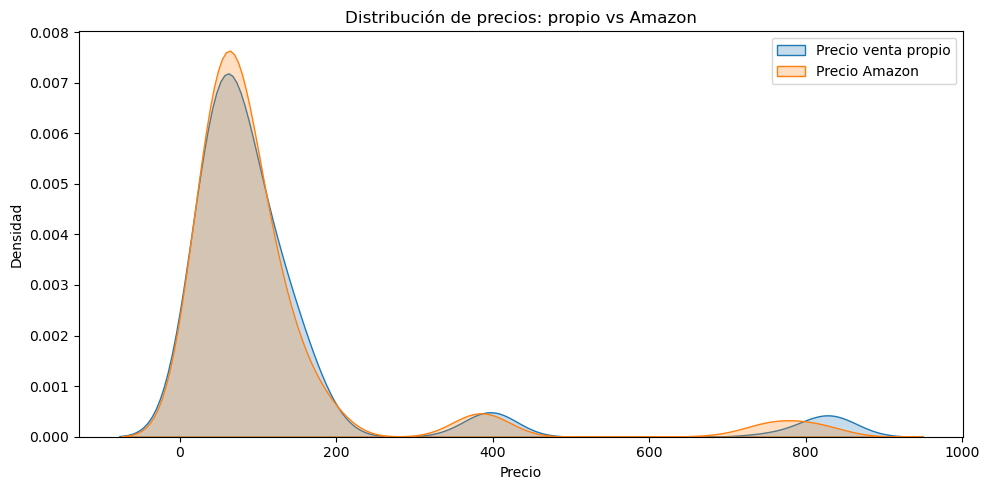

In [21]:
# 🤖 Análisis de densidad de precios propios vs Amazon
plt.figure(figsize=(10,5))
sns.kdeplot(df['precio_venta'], label='Precio venta propio', fill=True)
sns.kdeplot(df['Amazon'], label='Precio Amazon', fill=True)
plt.title('Distribución de precios: propio vs Amazon')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# 🤖 Creación de variables temporales usando holidays para España
import holidays
es_holidays = holidays.country_holidays('ES', years=df['fecha'].dt.year.unique())

df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia_mes'] = df['fecha'].dt.day
df['dia_semana'] = df['fecha'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['nombre_dia_semana'] = df['fecha'].dt.day_name()
df['es_fin_semana'] = df['dia_semana'].isin([5,6])
df['es_festivo'] = df['fecha'].isin(es_holidays)

# Black Friday: último viernes de noviembre
def es_black_friday(fecha):
    if fecha.month == 11:
        viernes_noviembre = pd.date_range(start=f'{fecha.year}-11-01', end=f'{fecha.year}-11-30', freq='W-FRI')
        return fecha in viernes_noviembre[-1:]
    return False

df['es_black_Friday'] = df['fecha'].apply(es_black_friday)

# Cyber Monday: primer lunes después de Black Friday
def es_cyber_monday(fecha):
    if fecha.month == 11 or fecha.month == 12:
        viernes_noviembre = pd.date_range(start=f'{fecha.year}-11-01', end=f'{fecha.year}-11-30', freq='W-FRI')
        if len(viernes_noviembre) > 0:
            black_friday = viernes_noviembre[-1]
            cyber_monday = black_friday + pd.Timedelta(days=3)
            return fecha == cyber_monday
    return False

df['es_cyber_Monday'] = df['fecha'].apply(es_cyber_monday)

# Variable: semana del año
df['semana_año'] = df['fecha'].dt.isocalendar().week
# Variable: trimestre
df['trimestre'] = df['fecha'].dt.quarter
# Variable: día laborable (no festivo y no fin de semana)
df['es_laborable'] = (~df['es_fin_semana']) & (~df['es_festivo'])

C:\Users\isaac\AppData\Local\Temp\ipykernel_19800\2971144242.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['es_festivo'] = df['fecha'].isin(es_holidays)


In [23]:
# 🤖 Creación de lags de unidades_vendidas (lag_1 a lag_7) y media móvil de 7 días
# Creamos los lags por año para no mezclar datos entre años

# Ordenar por producto_id, año y fecha para asegurar el orden correcto
df = df.sort_values(['producto_id', 'año', 'fecha'])

# Crear lags del 1 al 7 y media móvil de 7 días por producto y año
for lag in range(1, 8):
    df[f'lag_{lag}'] = df.groupby(['producto_id', 'año'])['unidades_vendidas'].shift(lag)

df['media_movil_7d'] = df.groupby(['producto_id', 'año'])['unidades_vendidas'].transform(
    lambda x: x.rolling(window=7, min_periods=7).mean().shift(1)
)

# Mostrar cuántos nulos tenemos antes de eliminar
print('Registros con nulos en las nuevas variables:')
print(df[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'media_movil_7d']].isnull().sum())

# Eliminar registros con nulos en las variables de lag o media móvil
df = df.dropna(subset=['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'media_movil_7d'])

print(f'\nRegistros después de eliminar nulos: {len(df)}')

Registros con nulos en las nuevas variables:
lag_1              96
lag_2             192
lag_3             288
lag_4             384
lag_5             480
lag_6             576
lag_7             672
media_movil_7d    672
dtype: int64

Registros después de eliminar nulos: 2880


In [26]:
# 🤖 Creación de variable descuento porcentaje
# Fórmula: ((precio_venta - precio_base) / precio_base) * 100
df['descuento_porcentaje'] = ((df['precio_venta'] - df['precio_base']) / df['precio_base']) * 100
df['descuento_porcentaje'] = df['descuento_porcentaje'].round(2)
df[['precio_base', 'precio_venta', 'descuento_porcentaje']].head()

,precio_base,precio_venta,descuento_porcentaje
168,115,115.07,0.06
192,115,116.10,0.96
216,115,114.58,-0.37
240,115,112.23,-2.41
264,115,113.81,-1.03


In [27]:
# 🤖 Creación de variable precio_competencia y ratio_precio
# Precio promedio de los competidores
competidores = ['Amazon', 'Decathlon', 'Deporvillage']
df['precio_competencia'] = df[competidores].mean(axis=1)
# Ratio de nuestro precio respecto al precio promedio de la competencia
df['ratio_precio'] = df['precio_venta'] / df['precio_competencia']
# Eliminar las columnas de los competidores
df = df.drop(columns=competidores)
df[['precio_venta', 'precio_competencia', 'ratio_precio']].head()

,precio_venta,precio_competencia,ratio_precio
168,115.07,95.353333,1.206775
192,116.10,96.153333,1.207446
216,114.58,95.240000,1.203066
240,112.23,96.590000,1.161922
264,113.81,96.170000,1.183425


In [28]:
# 🤖 Copia de variables categóricas y one hot encoding
# Crear copias con sufijo _h
df['nombre_h'] = df['nombre']
df['categoria_h'] = df['categoria']
df['subcategoria_h'] = df['subcategoria']

# One hot encoding sobre las nuevas variables
nombre_dummies = pd.get_dummies(df['nombre_h'], prefix='nombre_h')
categoria_dummies = pd.get_dummies(df['categoria_h'], prefix='categoria_h')
subcategoria_dummies = pd.get_dummies(df['subcategoria_h'], prefix='subcategoria_h')

# Concatenar al dataframe principal
df = pd.concat([df, nombre_dummies, categoria_dummies, subcategoria_dummies], axis=1)
df.head()

,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,...,subcategoria_h_Esterilla Yoga,subcategoria_h_Mancuernas Ajustables,subcategoria_h_Mochila Trekking,subcategoria_h_Pesa Rusa,subcategoria_h_Pesas Casa,subcategoria_h_Rodillera Yoga,subcategoria_h_Ropa Montaña,subcategoria_h_Ropa Running,subcategoria_h_Zapatillas Running,subcategoria_h_Zapatillas Trail
168,2021-11-01,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,7,115.07,805.49,...,False,False,False,False,False,False,False,False,True,False
192,2021-11-02,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,10,116.10,1161.00,...,False,False,False,False,False,False,False,False,True,False
216,2021-11-03,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,11,114.58,1260.38,...,False,False,False,False,False,False,False,False,True,False
240,2021-11-04,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,12,112.23,1346.76,...,False,False,False,False,False,False,False,False,True,False
264,2021-11-05,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,10,113.81,1138.10,...,False,False,False,False,False,False,False,False,True,False


In [29]:
df.nombre.unique()

array(['Nike Air Zoom Pegasus 40', 'Adidas Ultraboost 23',
       'Asics Gel Nimbus 25', 'New Balance Fresh Foam X 1080v12',
       'Nike Dri-FIT Miler', 'Adidas Own The Run Jacket',
       'Puma Velocity Nitro 2', 'Reebok Floatride Energy 5',
       'Bowflex SelectTech 552', 'Domyos BM900',
       'Reebok Professional Deck', 'Domyos Kit Mancuernas 20kg',
       'Decathlon Bandas Elásticas Set', 'Sveltus Kettlebell 12kg',
       'Salomon Speedcross 5 GTX', 'Trek Marlin 7',
       'The North Face Borealis', 'Columbia Silver Ridge',
       'Merrell Moab 2 GTX', 'Quechua MH500', 'Manduka PRO Yoga Mat',
       'Gaiam Premium Yoga Block', 'Liforme Yoga Pad',
       'Lotuscrafts Yoga Bolster'], dtype=object)

In [31]:
# 🤖 Guardar el dataframe procesado
df.to_csv('../data/processed/df.csv', index=False)
print('Archivo guardado en data/processed/df.csv')

Archivo guardado en data/processed/df.csv


In [33]:
# 🤖 División del dataframe en train y validation
train_df = df[df['año'].isin([2021, 2022, 2023])].copy()
validation_df = df[df['año'] == 2024].copy()
print(f'Registros en train_df: {len(train_df)}')
print(f'Registros en validation_df: {len(validation_df)}')

Registros en train_df: 2160
Registros en validation_df: 720


In [39]:
# 🤖 Entrenamiento y validación de HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Selección de variables predictoras
excluir = ['fecha', 'ingresos', 'unidades_vendidas']
object_cols = train_df.select_dtypes(include=['object']).columns.tolist()
features = [col for col in train_df.columns if col not in excluir + object_cols]

X_train = train_df[features]
y_train = train_df['unidades_vendidas']
X_val = validation_df[features]
y_val = validation_df['unidades_vendidas']

# Modelo conservador para evitar overfitting
model = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=400,
    max_depth=6,
    l2_regularization=1.0,
    random_state=42
)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_val)

# Baseline naive: predice la media de train
y_pred_naive = [y_train.mean()] * len(y_val)

# Métricas
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_val, y_pred)

mae_naive = mean_absolute_error(y_val, y_pred_naive)
mse_naive = mean_squared_error(y_val, y_pred_naive)
rmse_naive = sqrt(mse_naive)
r2_naive = r2_score(y_val, y_pred_naive)

print('--- Métricas HistGradientBoostingRegressor ---')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print('\n--- Métricas Baseline Naive (media) ---')
print(f'MAE: {mae_naive:.2f}')
print(f'MSE: {mse_naive:.2f}')
print(f'RMSE: {rmse_naive:.2f}')
print(f'R2: {r2_naive:.2f}')

--- Métricas HistGradientBoostingRegressor ---
MAE: 1.01
MSE: 4.57
RMSE: 2.14
R2: 0.90

--- Métricas Baseline Naive (media) ---
MAE: 3.67
MSE: 44.79
RMSE: 6.69
R2: -0.00


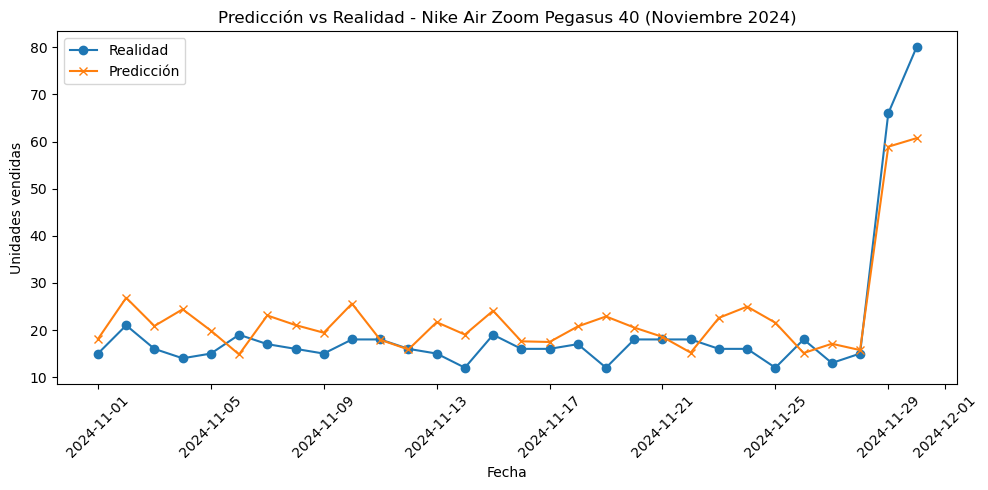

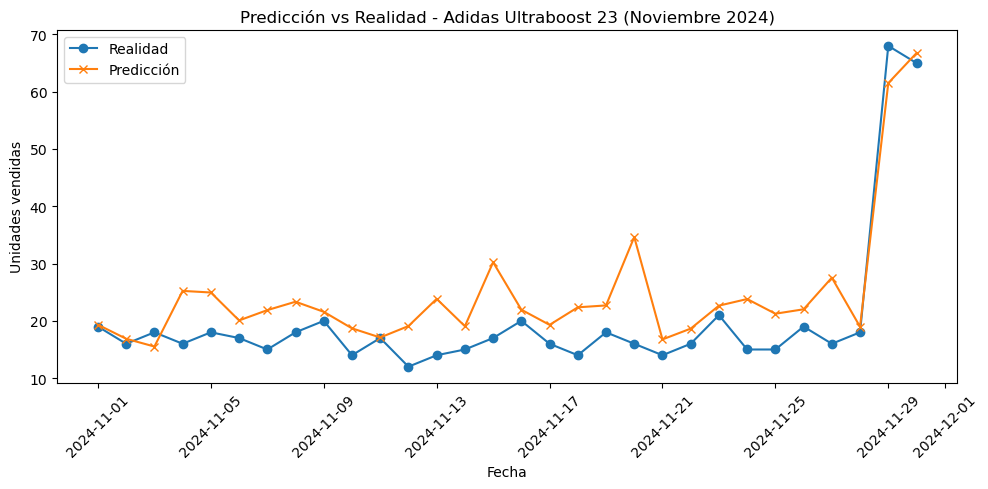

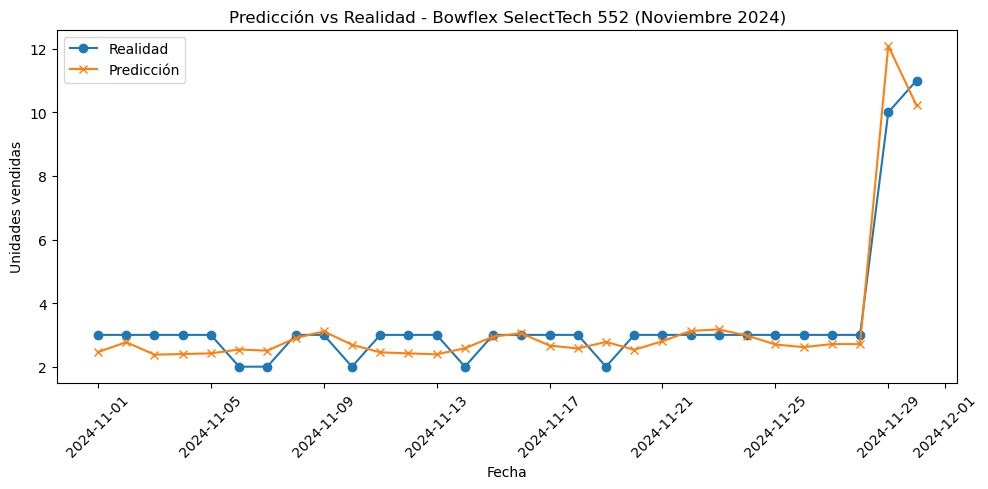

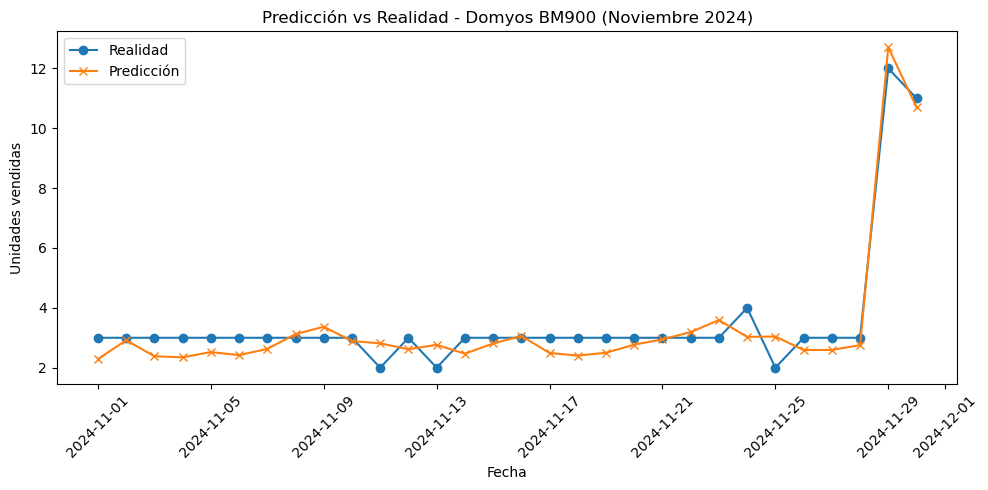

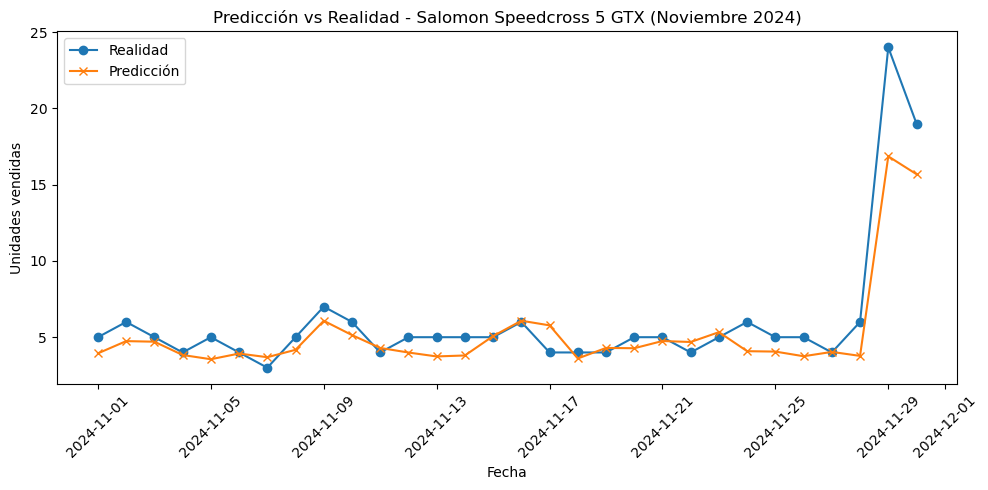

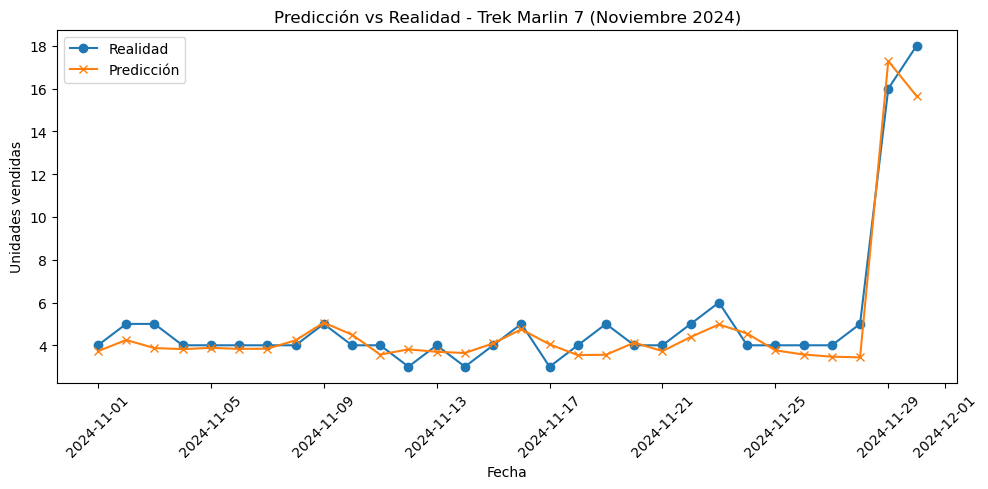

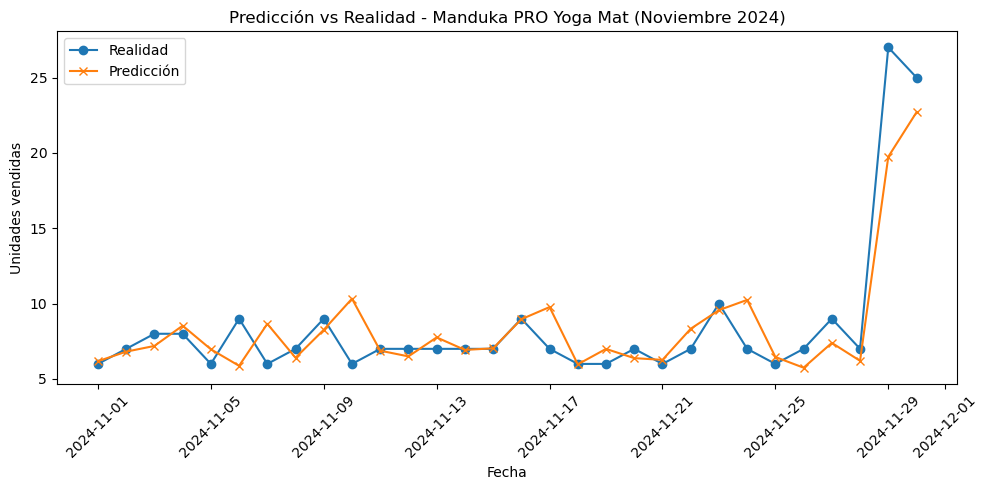

In [40]:
# 🤖 Predicción para productos estrella en noviembre 2024 y visualización
productos_estrella = validation_df[(validation_df['año'] == 2024) & (validation_df['mes'] == 11) & (validation_df['es_estrella'])]['nombre'].unique()

for producto in productos_estrella:
    df_prod = validation_df[(validation_df['año'] == 2024) & (validation_df['mes'] == 11) & (validation_df['nombre'] == producto)]
    X_prod = df_prod[features]
    y_real = df_prod['unidades_vendidas']
    y_pred = model.predict(X_prod)
    plt.figure(figsize=(10,5))
    plt.plot(df_prod['fecha'], y_real, label='Realidad', marker='o')
    plt.plot(df_prod['fecha'], y_pred, label='Predicción', marker='x')
    plt.title(f'Predicción vs Realidad - {producto} (Noviembre 2024)')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [41]:
# 🤖 Cálculo del MAE para cada producto estrella en noviembre 2024
mae_por_producto = {}
for producto in productos_estrella:
    df_prod = validation_df[(validation_df['año'] == 2024) & (validation_df['mes'] == 11) & (validation_df['nombre'] == producto)]
    X_prod = df_prod[features]
    y_real = df_prod['unidades_vendidas']
    y_pred = model.predict(X_prod)
    mae = mean_absolute_error(y_real, y_pred)
    mae_por_producto[producto] = mae
    print(f"Producto: {producto:40s} | MAE: {mae:.2f}")

Producto: Nike Air Zoom Pegasus 40                 | MAE: 5.27
Producto: Adidas Ultraboost 23                     | MAE: 5.28
Producto: Bowflex SelectTech 552                   | MAE: 0.45
Producto: Domyos BM900                             | MAE: 0.45
Producto: Salomon Speedcross 5 GTX                 | MAE: 1.09
Producto: Trek Marlin 7                            | MAE: 0.60
Producto: Manduka PRO Yoga Mat                     | MAE: 1.30


Periodo 1-10 | MAE: 1.88 | RMSE: 3.07 | R2: 0.73
Periodo 11-20 | MAE: 1.97 | RMSE: 3.93 | R2: 0.50
Periodo 21-30 | MAE: 2.34 | RMSE: 4.08 | R2: 0.93


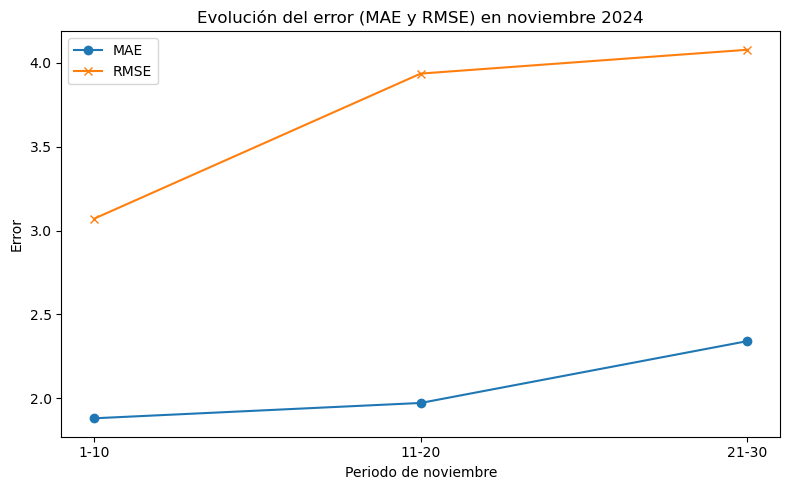

In [42]:
# 🤖 Análisis de la degradación del error en noviembre 2024 por periodos de 10 días
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
periodos = [(1,10), (11,20), (21,30)]
metricas_periodo = []
for i, (inicio, fin) in enumerate(periodos, 1):
    df_periodo = validation_df[(validation_df['año'] == 2024) & (validation_df['mes'] == 11) & (validation_df['dia_mes'] >= inicio) & (validation_df['dia_mes'] <= fin) & (validation_df['es_estrella'])]
    if len(df_periodo) == 0:
        continue
    X_periodo = df_periodo[features]
    y_real = df_periodo['unidades_vendidas']
    y_pred = model.predict(X_periodo)
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    metricas_periodo.append({'Periodo': f'{inicio}-{fin}', 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f'Periodo {inicio}-{fin} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2f}')
# Graficar la evolución del MAE y RMSE
if metricas_periodo:
    plt.figure(figsize=(8,5))
    plt.plot([m['Periodo'] for m in metricas_periodo], [m['MAE'] for m in metricas_periodo], marker='o', label='MAE')
    plt.plot([m['Periodo'] for m in metricas_periodo], [m['RMSE'] for m in metricas_periodo], marker='x', label='RMSE')
    plt.title('Evolución del error (MAE y RMSE) en noviembre 2024')
    plt.xlabel('Periodo de noviembre')
    plt.ylabel('Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

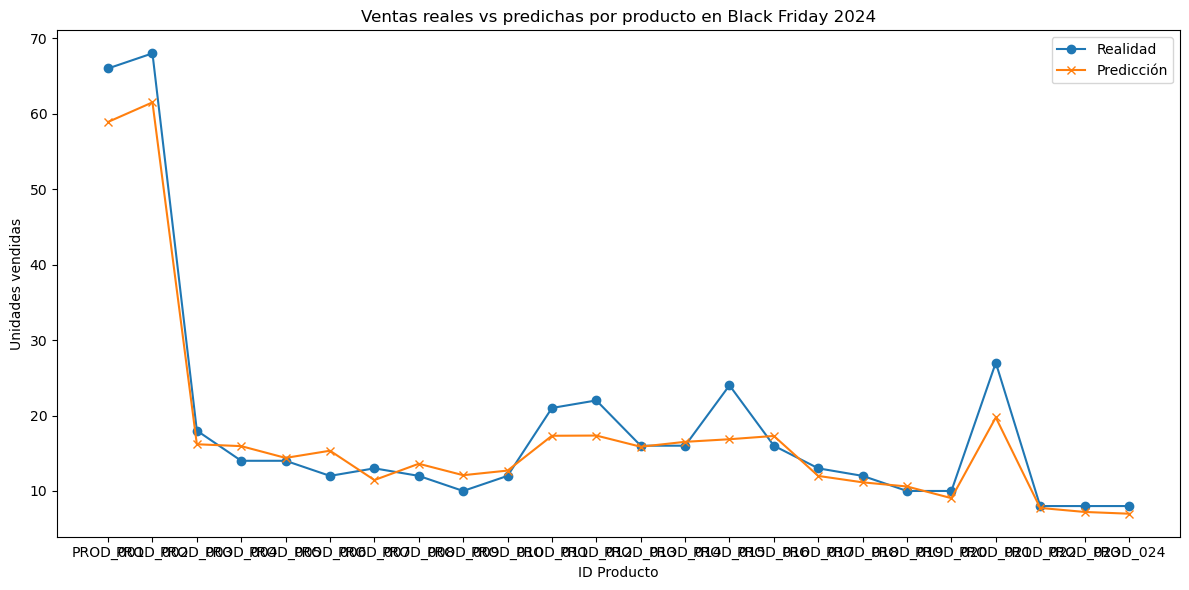

In [43]:
# 🤖 Análisis y gráfico de ventas reales vs predichas en Black Friday 2024 para todos los productos
df_bf = validation_df[(validation_df['año'] == 2024) & (validation_df['es_black_Friday'])]
if len(df_bf) == 0:
    print('No hay registros para Black Friday 2024.')
else:
    X_bf = df_bf[features]
    y_real_bf = df_bf['unidades_vendidas']
    y_pred_bf = model.predict(X_bf)
    producto_ids = df_bf['producto_id']
    plt.figure(figsize=(12,6))
    plt.plot(producto_ids, y_real_bf, label='Realidad', marker='o')
    plt.plot(producto_ids, y_pred_bf, label='Predicción', marker='x')
    plt.title('Ventas reales vs predichas por producto en Black Friday 2024')
    plt.xlabel('ID Producto')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [44]:
# 🤖 Reentrenamiento del modelo final con todos los datos históricos (2021-2024)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
excluir = ['fecha', 'ingresos', 'unidades_vendidas']
object_cols = df.select_dtypes(include=['object']).columns.tolist()
features_final = [col for col in df.columns if col not in excluir + object_cols]
X_final = df[features_final]
y_final = df['unidades_vendidas']
modelo_final = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=400,
    max_depth=6,
    l2_regularization=1.0,
    random_state=42
)
modelo_final.fit(X_final, y_final)
print('Modelo final entrenado con todos los datos históricos (2021-2024).')

Modelo final entrenado con todos los datos históricos (2021-2024).


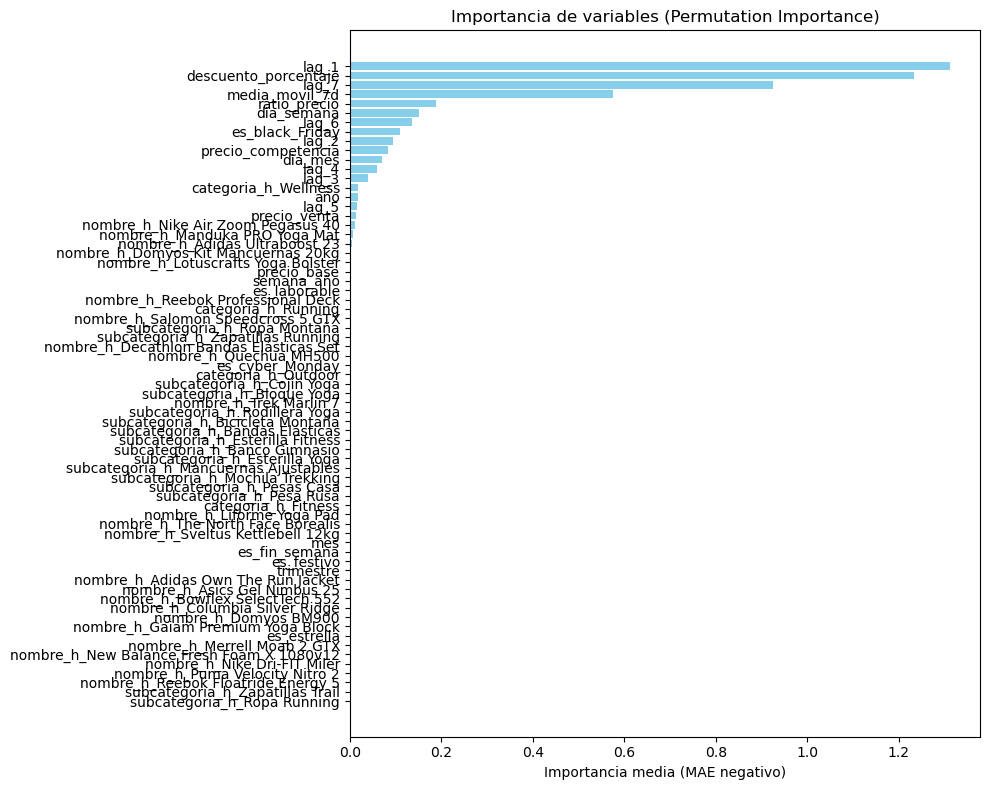

Modelo final guardado en models/modelo_final.joblib


In [45]:
# 🤖 Importancia de variables con permutation_importance y guardado del modelo final
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
result = permutation_importance(modelo_final, X_final, y_final, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importancia = pd.DataFrame({'variable': features_final, 'importancia': result.importances_mean})
importancia = importancia.sort_values('importancia', ascending=False)
plt.figure(figsize=(10,8))
plt.barh(importancia['variable'], importancia['importancia'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Importancia de variables (Permutation Importance)')
plt.xlabel('Importancia media (MAE negativo)')
plt.tight_layout()
plt.show()
joblib.dump(modelo_final, '../models/modelo_final.joblib')
print('Modelo final guardado en models/modelo_final.joblib')